In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [22]:
# import dataset (comes with colab)
dataFull = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

# now for the function
def makeTheDataset(N, doubleTheData = False):

    # extract labels
    labels = dataFull[:N, 0]
    data = dataFull[:N, 1:]

    # normalize the data to a range of [0 , 1]
    dataNorm = data/np.max(data)

    # make an exact copu of all the data
    if doubleTheData:
        dataNorm = np.concatenate((dataNorm, dataNorm), axis = 0)
        labels = np.concatenate((labels, labels), axis = 0)

    # convert to tensor
    dataT = torch.tensor(dataNorm).float()
    labels = torch.tensor(labels).long()


    # train test split
    train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = .2)

    ## make an exact copy of the Train data
    # if doubleTheData:
        # train_data = torch.cat((train_data, train_data), axis = 0)
        # train_labels = torch.cat((train_labels, train_labels), axis = 0)

    # converting into tensorDataset
    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    # trainslate into dataloader objects
    batchsize = 20
    train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
    test_loader = DataLoader(test_data, batch_size = len(test_data))

    return train_loader, test_loader


In [23]:
# create a class for the model
def createTheMNISTNet():

    class mnistNet(nn.Module):

        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        def forward(self, X):

            X = F.relu(self.input(X))
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc2(X))

            return self.output(X)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01)

    return net, lossfun, optimizer




In [29]:
def function2trainTheModel():

    # number of epochs
    numepochs = 50

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    losses = np.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            # matches
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracypct = 100 * torch.mean(matches)
            batchAcc.append(accuracypct)

        losses[epochi] = np.mean(batchLoss)
        trainAcc.append(np.mean(batchAcc))

        # test
        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            matches = (torch.argmax(yHat, axis = 1) == y).float()
            accuracypct = 100 * torch.mean(matches)
            testAcc.append(accuracypct)

    return trainAcc, testAcc, losses, net


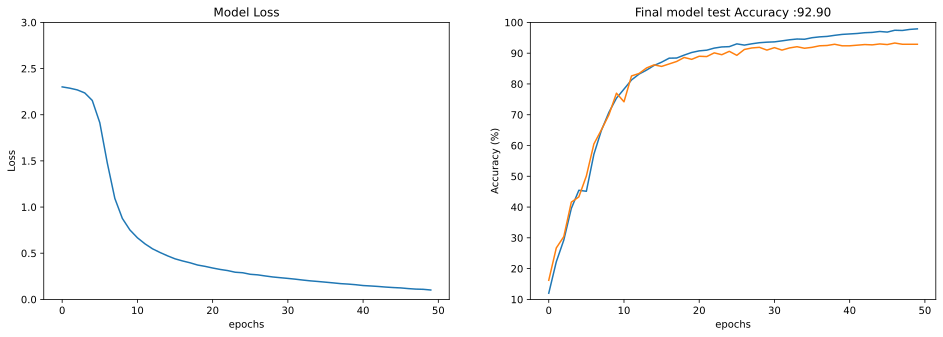

In [30]:
train_loader, test_loader = makeTheDataset(5000)

# testing it
trainAcc, testAcc, losses, net = function2trainTheModel()

# plot the results
fig, ax = plt.subplots(1, 2, figsize = (16,5))

ax[0].plot(losses)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label = 'Train')
ax[1].plot(testAcc, label = 'Test')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test Accuracy :{testAcc[-1]:.2f}")
plt.show()

In [36]:
samplesizes = np.arange(500, 4001, 500)

# initilize results matrix
resultsSingle = np.zeros((len(samplesizes), 3))
resultsDouble = np.zeros((len(samplesizes), 3))

for idx, ssize in enumerate(samplesizes):

    # generate a dataset and train a model
    train_loader, test_loader = makeTheDataset(ssize, False)
    trainAcc, testAcc, losses, net = function2trainTheModel()

    # store the results
    resultsSingle[idx, 0] = np.mean(trainAcc[-5:])
    resultsSingle[idx, 1] = np.mean(testAcc[-5:])
    resultsSingle[idx, 2] = np.mean(losses[-5:])

    ## with doubling the data

    # generate a dataset and train the model
    train_loader, test_loader = makeTheDataset(ssize, True)
    trainAcc, testAcc, losses, net = function2trainTheModel()

    # store the results
    resultsDouble[idx, 0] = np.mean(trainAcc[-5:])
    resultsDouble[idx, 1] = np.mean(testAcc[-5:])
    resultsDouble[idx, 2] = np.mean(losses[-5:])


87.78625


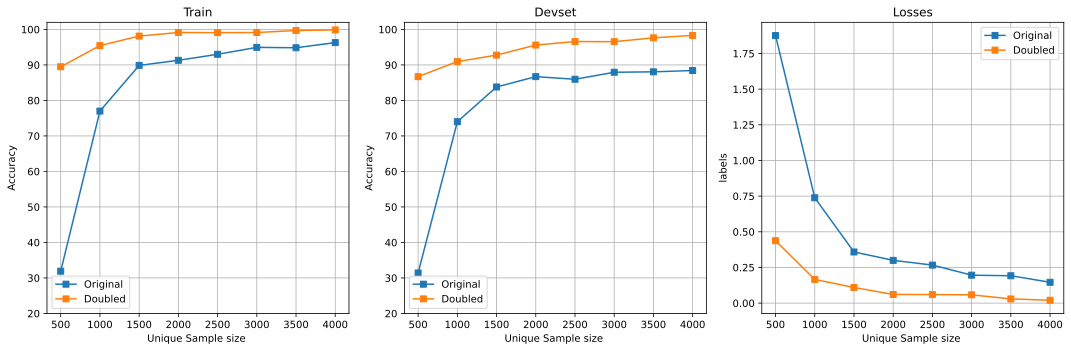

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

# axis and title labels
title = ['Train', 'Devset', 'Losses']
yaxlabels = ['Accuracy', 'Accuracy', 'labels']

for i in range(3):

    ax[i].plot(samplesizes, resultsSingle[:, i], 's-', label = 'Original')
    ax[i].plot(samplesizes, resultsDouble[:, i], 's-', label = 'Doubled')


    # make it look nicer
    ax[i].set_ylabel(yaxlabels[i])
    ax[i].set_title(title[i])
    ax[i].legend()
    ax[i].set_xlabel('Unique Sample size ')
    ax[i].grid('on')

    if i < 2:
        ax[i].set_ylim([20, 102])

plt.tight_layout()
plt.show()